| Name | Surname | ID Number |
|------|---------|---------------------|
| Lorenzo | Calandra Buonaura | 2107761 |

In [24]:
library("dplyr", warn.conflicts = FALSE)
library("ggplot2", warn.conflicts = FALSE)
library("geosphere", warn.conflicts = FALSE)
library("spatstat", warn.conflicts = FALSE)
library("gridExtra", warn.conflicts = FALSE)

# Exercise 1: Bayesian Inference for Poisson model

The number of particles emitted by a radioactive source during a fixed interval of time ($\Delta t = 10 s$) follows a Poisson distribution on the parameter $\mu$. The number of particles observed during consecutive time intervals is: 4, 1, 3, 1, 5 and 3.

(a) Assuming a positive uniform prior distribution for the parameter $\mu$:
- determine and draw the posterior distribution for $\mu$, given the data;
- evaluate mean, median and variance, both analytically and numerically in R.

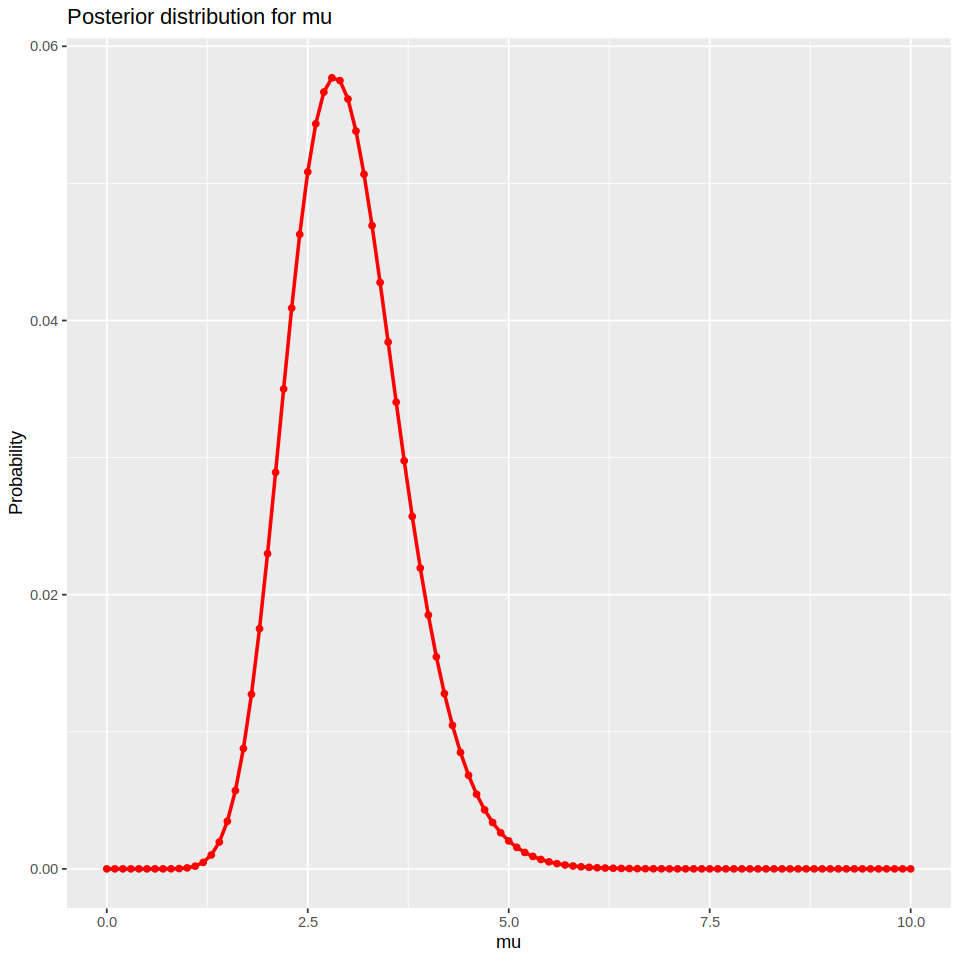

In [25]:
delta_t <- 10
num_occ <- c(4, 1, 3, 1, 5, 3)

post_un <- function(x, mu, limits) {
  uniform <- 1 / (limits[2] - limits[1])
  n <- length(x)
  exp <- sum(x)

  normalization <- sum(uniform * exp(-mu * n) * (mu) **(exp))

  return(uniform * exp(- mu * n) * (mu)**(exp) / normalization)
}

mu <- seq(0, 10, 0.1)
post_values <- post_un(num_occ, mu, c(min(mu), max(mu)))

options(repr.plot.width = 8, repr.plot.height = 8)

ggplot(data = data.frame(mu, post_values), aes(x = mu, y = post_values)) +
  geom_point(color = "red", size = 1.5) +
  geom_line(color = "red", linewidth = 1) +
  labs(title = "Posterior distribution for mu",
       x = "mu",
       y = "Probability")

In [26]:
mean_analytical <- sum(mu * post_values)
variance_analytical <- sum((mu**2) * post_values) - mean_analytical**2

cdf_post <- function(x, post_val) {
  result <- 0
  for (i in 1:x){
    result <- result + post_val[i]
  }

  return(result)
}

median_index <- round(uniroot(function(x) cdf_post(x, post_values) - 0.5,
                              lower = 1, upper = length(mu))$root)
median_analytical <- mu[median_index]

mean_numerical <- weighted.mean(mu, post_values)
median_numerical <- weighted.median(mu, post_values)
variance_numerical <- weighted.var(mu, post_values)

cat("Analytical Mean:", mean_analytical, "\n")
cat("Analytical Median:", median_analytical, "\n")
cat("Analytical Variance:", variance_analytical, "\n \n")

cat("Numerical Mean:", mean_numerical, "\n")
cat("Numerical Median:", median_numerical, "\n")
cat("Numerical Variance:", variance_numerical, "\n")


Analytical Mean: 3 
Analytical Median: 2.9 
Analytical Variance: 0.5 
 
Numerical Mean: 3 
Numerical Median: 2.85 
Numerical Variance: 0.5212406 


(b) assuming a Gamma prior such that the expected value is $\mu = 3$ with a standard deviation $\sigma = 1$:
- determine and draw the posterior distribution for $\mu$, given the data:
- evaluate mean, median and variance, both analytically and numerically in R.

First of all we need to compute the parameters of the Gamma distribution with $\mu = 3$ and $\sigma = 1$:

$
\begin{cases} 
\mu = \alpha \beta \\
\sigma ^ 2 = \alpha \beta^2
\end{cases}
$

From this we get: $\alpha = 9$ and $\beta = 1/3$.

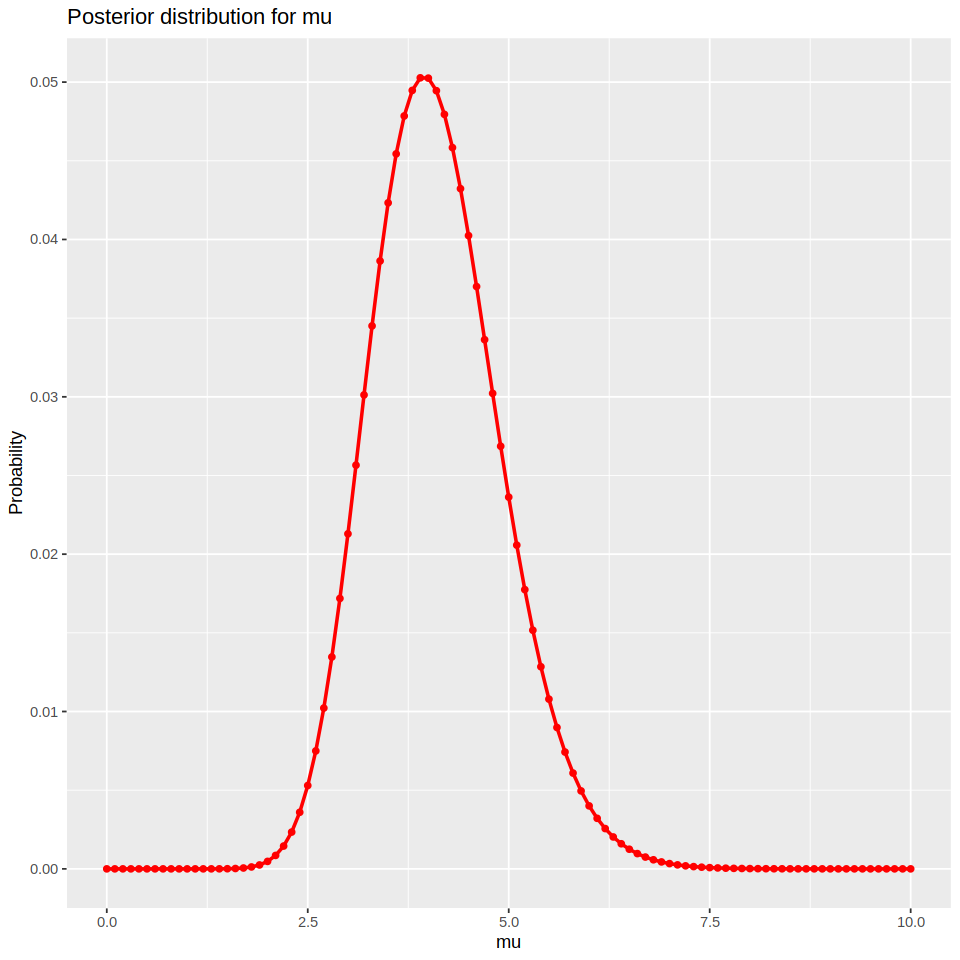

In [27]:
post_gam <- function(x, mu, alpha, beta) {
  gamma <- dgamma(mu, shape = alpha, rate = beta)
  n <- length(x)
  exp <- sum(x)

  normalization <- sum(gamma * exp(-mu * n) * (mu) **(exp))

  return(gamma * exp(- mu * n) * (mu)**(exp) / normalization)
}

mu <- seq(0, 10, 0.1)
alpha <- 9
beta <- 1 / 3
post_values_gamma <- post_gam(num_occ, mu, alpha, beta)

ggplot(data = data.frame(mu, post_values_gamma),
       aes(x = mu, y = post_values_gamma)) +
  geom_point(color = "red", size = 1.5) +
  geom_line(color = "red", linewidth = 1) +
  labs(title = "Posterior distribution for mu",
       x = "mu",
       y = "Probability")

In [28]:
mean_analytical <- sum(mu * post_values_gamma)
variance_analytical <- sum((mu**2) * post_values_gamma) - mean_analytical**2

median_index <- round(uniroot(function(x) cdf_post(x, post_values_gamma) - 0.5,
                              lower = 1, upper = length(mu))$root)
median_analytical <- mu[median_index]

mean_numerical <- weighted.mean(mu, post_values_gamma)
median_numerical <- weighted.median(mu, post_values_gamma)
variance_numerical <- weighted.var(mu, post_values_gamma)

cat("Analytical Mean:", mean_analytical, "\n")
cat("Analytical Median:", median_analytical, "\n")
cat("Analytical Variance:", variance_analytical, "\n \n")

cat("Numerical Mean:", mean_numerical, "\n")
cat("Numerical Median:", median_numerical, "\n")
cat("Numerical Variance:", variance_numerical, "\n")

Analytical Mean: 4.105263 
Analytical Median: 4.1 
Analytical Variance: 0.6481983 
 
Numerical Mean: 4.105263 
Numerical Median: 4.05 
Numerical Variance: 0.6720938 


(c) evaluate a 95% credibility interval for the results obtained with different priors. Compare the result with that obtained using a normal approximation for the posterior distribution, with the same mean and standard deviation.

In [29]:
c_int <- function(val, int, param) {
  low <- 0
  up <- 0
  a <- 1
  b <- 1

  limits <- c((1 - int) / 2, (1 + int) / 2)

  while (low < limits[1]) {
    low <- low + val[a]
    a <- a + 1
  }

  while (up < limits[2]) {
    up <- up + val[b]
    b <- b + 1
  }

  if (b > length(param)) {
    b <- length(param)
  }

  return(c(param[a], param[b]))
}

norm_values <- dnorm(mu, mean = 3, sd = 1)
const <- sum(norm_values)
norm_values <- norm_values / const

un_c_int <- c_int(post_values, 0.95, mu)
gamma_c_int <- c_int(post_values_gamma, 0.95, mu)
norm_c_int <- c_int(norm_values, 0.95, mu)

cat("95% Credibility Interval for Uniform prior: (", un_c_int[1], ",", un_c_int[2], ")\n") # nolinter
cat("95% Credibility Interval for Gamma prior: (", gamma_c_int[1], ",", gamma_c_int[2], ")\n") # nolinter
cat("95% Credibility Interval for Normal posterior: (", norm_c_int[1], ",", norm_c_int[2], ")\n") # nolinter

95% Credibility Interval for Uniform prior: ( 1.9 , 4.6 )
95% Credibility Interval for Gamma prior: ( 2.8 , 5.9 )
95% Credibility Interval for Normal posterior: ( 1.2 , 5.1 )


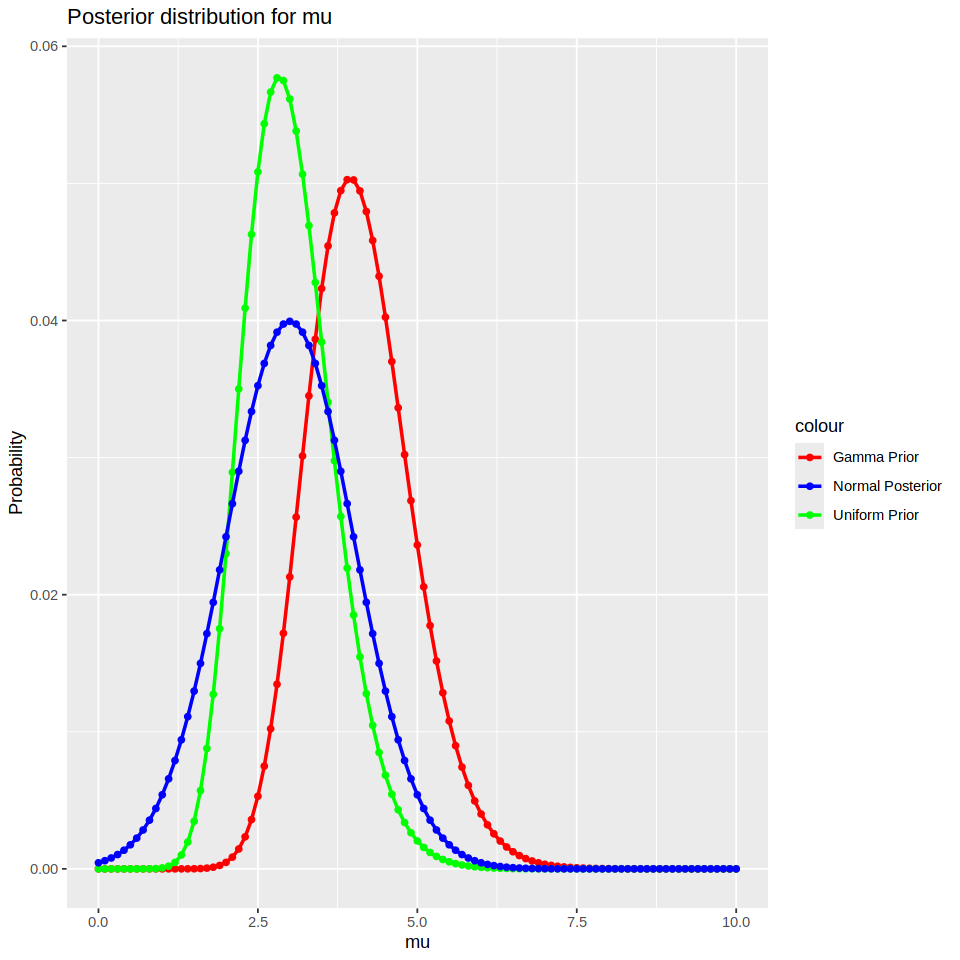

In [30]:
ggplot(data = data.frame(mu, post_values_gamma, post_values, norm_values),
       aes(x = mu)) +
  geom_point(aes(y = post_values_gamma, color = "Gamma Prior"), size = 1.5) +
  geom_line(aes(y = post_values_gamma, color = "Gamma Prior"), linewidth = 1) +
  geom_point(aes(y = post_values, color = "Uniform Prior"), size = 1.5) +
  geom_line(aes(y = post_values, color = "Uniform Prior"), linewidth = 1) +
  geom_point(aes(y = norm_values, color = "Normal Posterior"), size = 1.5) +
  geom_line(aes(y = norm_values, color = "Normal Posterior"), linewidth = 1) +
  labs(title = "Posterior distribution for mu",
       x = "mu",
       y = "Probability") +
  scale_color_manual(values = c("red", "blue", "green"),
                     labels = c("Gamma Prior", "Normal Posterior",
                                "Uniform Prior"))

# Exercise 2: Efficiency using Bayesian approach

A researcher A wants to evaluate the efficiency of detector 2 (Det2). For this purpose, he sets up the apparatus shown in the figure 1, where Det2 is sandwiched between Det1 and Det3. Let $n$ be the number of signals recorded simultaneously by Det1 and Det3, and
$r$ be those also recorded by Det2, researcher A obtains $n = 500$ and $r = 312$. Assuming a binomial model where $n$ is the number of trials and $r$ is the number of success out of $n$ trials:

(a) Evaluate the mean and the variance using a Bayesian approach under the hypothesis of:
- uniform prior ∼ U(0,1)
- Jeffrey’s prior ∼ Beta(1/2,1/2)

In [31]:
post_un_bern <- function(r, n, limits, p) {
  uniform <- 1 / (limits[2] - limits[1])
  normalization <- sum(uniform * dbinom(r, n, p))

  return(uniform * dbinom(r, n, p) / normalization)
}

post_beta_bern <- function(r, n, params, p) {
  beta <- dbeta(p, params[1], params[2])
  normalization <- sum(beta * dbinom(r, n, p))

  return(beta * dbinom(r, n, p) / normalization)
}

r <- 312
n <- 500
a <- 1 / 2
b <- 1 / 2
p <- seq(0.01, 1 - 0.01, 0.01)

bern_un_values <- post_un_bern(r, n, c(min(p), max(p)), p)
bern_beta_values <- post_beta_bern(r, n, c(a, b), p)

cat("Mean with Uniform prior:", weighted.mean(p, bern_un_values), "\n")
cat("Variance with Uniform prior:", weighted.var(p, bern_un_values), "\n")
cat("Mean with Beta prior:", weighted.mean(p, bern_beta_values), "\n")
cat("Variance with Beta prior:", weighted.var(p, bern_beta_values), "\n")

Mean with Uniform prior: 0.623506 
Variance with Uniform prior: 0.0005367422 
Mean with Beta prior: 0.6237525 
Variance with Beta prior: 0.0005376019 


(b) Plot the posterior distributions for both cases

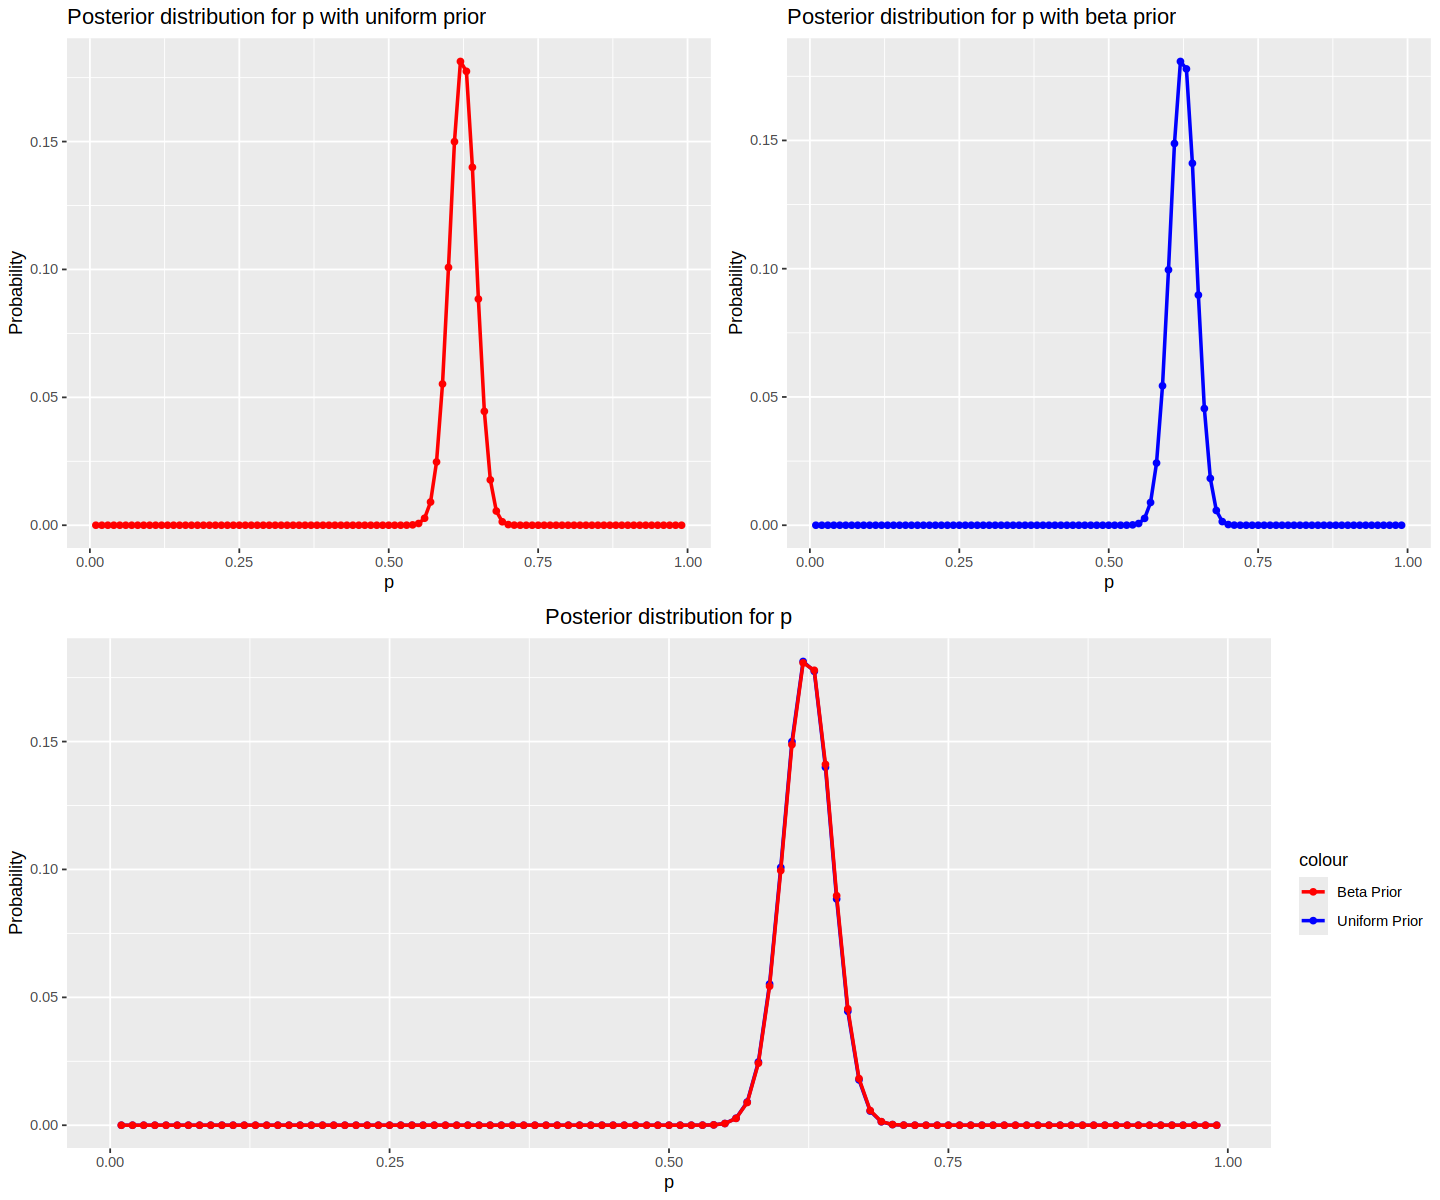

In [32]:
un_plot <- ggplot(data = data.frame(p, bern_un_values),
                  aes(x = p, y = bern_un_values)) +
  geom_point(color = "red", size = 1.5) +
  geom_line(color = "red", linewidth = 1) +
  labs(title = "Posterior distribution for p with uniform prior",
       x = "p",
       y = "Probability")

beta_plot <- ggplot(data = data.frame(p, bern_beta_values),
                    aes(x = p, y = bern_beta_values)) +
  geom_point(color = "blue", size = 1.5) +
  geom_line(color = "blue", linewidth = 1) +
  labs(title = "Posterior distribution for p with beta prior",
       x = "p",
       y = "Probability")

mixed_plot <- ggplot(data = data.frame(p, bern_un_values, bern_beta_values),
                     aes(x = p)) +
  geom_point(aes(y = bern_un_values, color = "Uniform Prior"), size = 1.5) +
  geom_line(aes(y = bern_un_values, color = "Uniform Prior"), linewidth = 1) +
  geom_point(aes(y = bern_beta_values, color = "Beta Prior"), size = 1.5) +
  geom_line(aes(y = bern_beta_values, color = "Beta Prior"), linewidth = 1) +
  labs(title = "Posterior distribution for p",
       x = "p",
       y = "Probability") +
  scale_color_manual(values = c("red", "blue"),
                     labels = c("Beta Prior", "Uniform Prior")) +
  theme(plot.title = element_text(hjust = 0.5))

options(repr.plot.width = 12, repr.plot.height = 10)
grid.arrange(un_plot, beta_plot, mixed_plot,
             layout_matrix = rbind(c(1, 2), c(3, 3)))

Taking into account that the same detector has been studied by researcher B, who has performed only $n = 10$ measurements and has obtained $r = 10$ signals: 

(c) Evaluate the mean, the variance and the posterior distribution using a uniform prior with the results of researcher B.

Mean with Uniform prior for researcher B: 0.9119989 
Variance with Uniform prior for researcher B: 0.006166099 


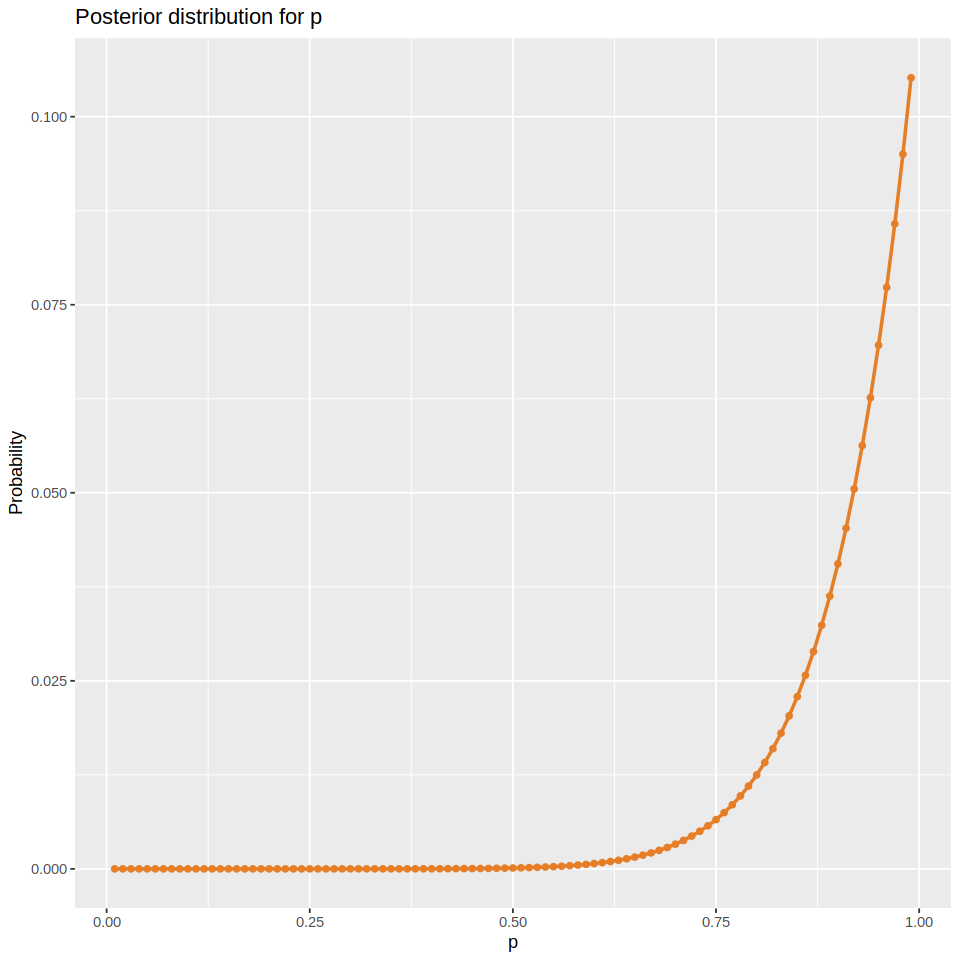

In [33]:
n_b <- 10
r_b <- 10

bern_un_values_b <- post_un_bern(r_b, n_b, c(min(p), max(p)), p)

cat("Mean with Uniform prior for researcher B:", weighted.mean(p, bern_un_values_b), "\n") # nolinter
cat("Variance with Uniform prior for researcher B:", weighted.var(p, bern_un_values_b), "\n") # nolinter

options(repr.plot.width = 8, repr.plot.height = 8)

ggplot(data = data.frame(p, bern_un_values_b),
       aes(x = p, y = bern_un_values_b)) +
  geom_point(color = "#e67e28", size = 1.5) +
  geom_line(color = "#e67e28", linewidth = 1) +
  labs(title = "Posterior distribution for p",
       x = "p",
       y = "Probability")

(d) Repeat the computation of points (a) and (b) with the data of researcher A using as a prior the posterior obtained from point (c).

Mean with Uniform prior for researcher B: 0.6308594 
Variance with Uniform prior for researcher B: 0.0005231835 


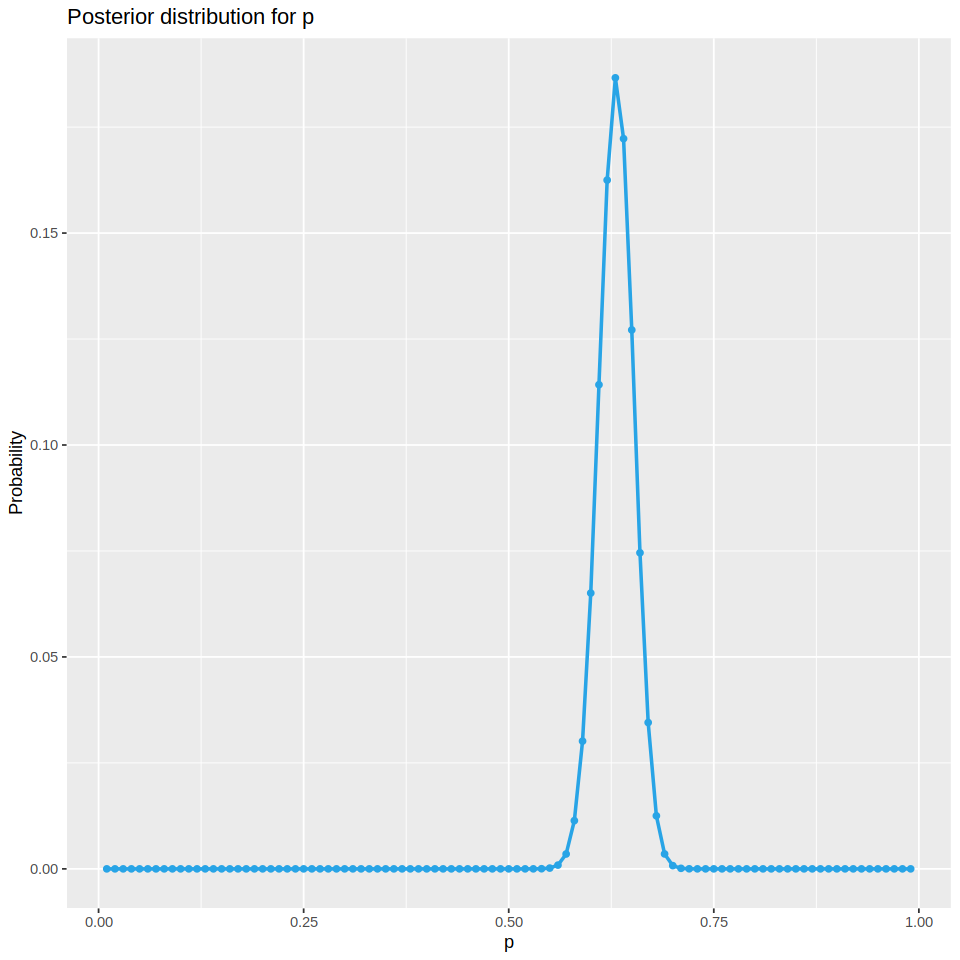

In [34]:
post_bern_b <- function(r, n, prior_values, p) {
  normalization <- sum(prior_values * dbinom(r, n, p))
  return(prior_values * dbinom(r, n, p) / normalization)
}

post_bern_values_b <- post_bern_b(r, n, bern_un_values_b, p)

cat("Mean with Uniform prior for researcher B:", weighted.mean(p, post_bern_values_b), "\n") # nolinter
cat("Variance with Uniform prior for researcher B:", weighted.var(p, post_bern_values_b), "\n") # nolinter

ggplot(data = data.frame(p, post_bern_values_b),
       aes(x = p, y = post_bern_values_b)) +
  geom_point(color = "#28a4e6", size = 1.5) +
  geom_line(color = "#28a4e6", linewidth = 1) +
  labs(title = "Posterior distribution for p",
       x = "p",
       y = "Probability")

(e) [Optional] Compute 95% credible interval using the posterior of the previous point (d)

In [35]:
# USING c_int FUNCTION PREVIOUSLY DEFINED

bern_c_int <- c_int(post_bern_values_b, 0.95, p)

cat("95% Credibility Interval: (", bern_c_int[1], ",", bern_c_int[2], ")\n") # nolinter

95% Credibility Interval: ( 0.6 , 0.68 )


# Exercise 3 - Bayesian Inference for Binomial model

A coin is flipped $n = 30$ times with the following outcomes: T, T, T, T, T, H, T, T, H, H, T, T, H, H, H, T, H, T, H, T, H, H, T, H, T, H, T, H, H, H

(a) Assuming a flat prior, and a beta prior, plot the likelihood, prior and posterior distributions for the data set.

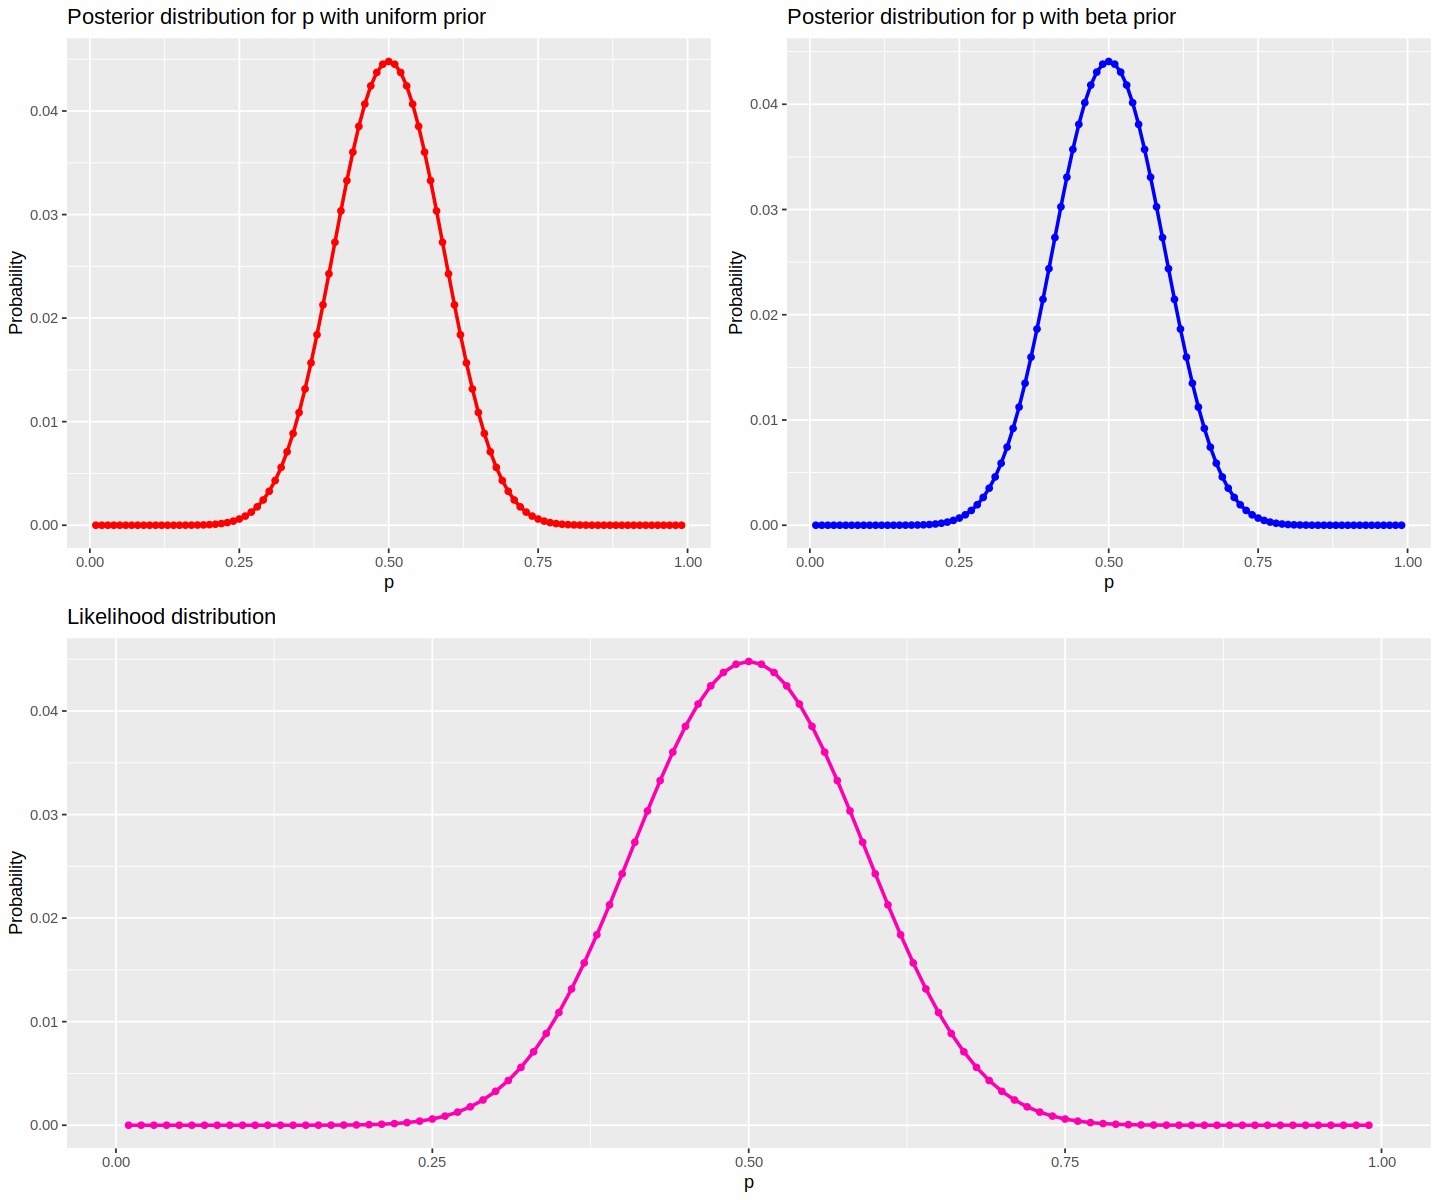

In [36]:
data <- c(1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
          0, 0, 1, 0, 1, 0, 1, 0, 0, 0)

n_coin <- length(data)
r_coin <- sum(data)
a <- 1 / 2
b <- 1 / 2

p <- seq(0.01, 1 - 0.01, 0.01)

likelihood <- function(n, r, p) {
  binomial_likelihood <- dbinom(r_coin, n_coin, p)

  return(binomial_likelihood / sum(binomial_likelihood))
}

likelihood_val <- likelihood(n_coin, r_coin, p)
coin_un_val <- post_un_bern(r_coin, n_coin, c(min(p), max(p)), p)
coin_beta_val <- post_beta_bern(r_coin, n_coin, c(a, b), p)

coin_un_plot <- ggplot(data = data.frame(p, coin_un_val),
                       aes(x = p, y = coin_un_val)) +
  geom_point(color = "red", size = 1.5) +
  geom_line(color = "red", linewidth = 1) +
  labs(title = "Posterior distribution for p with uniform prior",
       x = "p",
       y = "Probability")

coin_beta_plot <- ggplot(data = data.frame(p, coin_beta_val),
                         aes(x = p, y = coin_beta_val)) +
  geom_point(color = "blue", size = 1.5) +
  geom_line(color = "blue", linewidth = 1) +
  labs(title = "Posterior distribution for p with beta prior",
       x = "p",
       y = "Probability")

likelihood_plot <- ggplot(data = data.frame(p, likelihood_val),
                          aes(x = p, y = likelihood_val)) +
  geom_point(color = "#ff00ae", size = 1.5) +
  geom_line(color = "#ff00ae", linewidth = 1) +
  labs(title = "Likelihood distribution",
       x = "p",
       y = "Probability")

options(repr.plot.width = 12, repr.plot.height = 10)
grid.arrange(coin_un_plot, coin_beta_plot, likelihood_plot,
             layout_matrix = rbind(c(1, 2), c(3, 3)))

(b) Evaluate the most probable value for the coin probability p and, integrating the posterior probability distribution, give an estimate for a 95% credibility interval.

In [37]:
most_prob_un <- weighted.mean(p, coin_un_val)
most_prob_beta <- weighted.mean(p, coin_beta_val)

coin_un_c_int <- c_int(coin_un_val, 0.95, p)
coin_beta_c_int <- c_int(coin_beta_val, 0.95, p)

cat("Most probable value with uniform prior:", most_prob_un, "\n")
cat("Most probable value with beta prior:", most_prob_beta, "\n")

cat("95% credibility interval with uniform prior: (", coin_un_c_int[1], ",", coin_un_c_int[2], ")\n") # nolinter
cat("95% credibility interval with beta prior: (", coin_beta_c_int[1], ",", coin_beta_c_int[2], ")") # nolinter

Most probable value with uniform prior: 0.5 
Most probable value with beta prior: 0.5 
95% credibility interval with uniform prior: ( 0.34 , 0.68 )
95% credibility interval with beta prior: ( 0.34 , 0.68 )

(c) Repeat the same analysis assuming a sequential analysis of the data. Show how the most probable value and the credibility interval change as a function of the number of coin tosses (i.e. from 1 to 30).

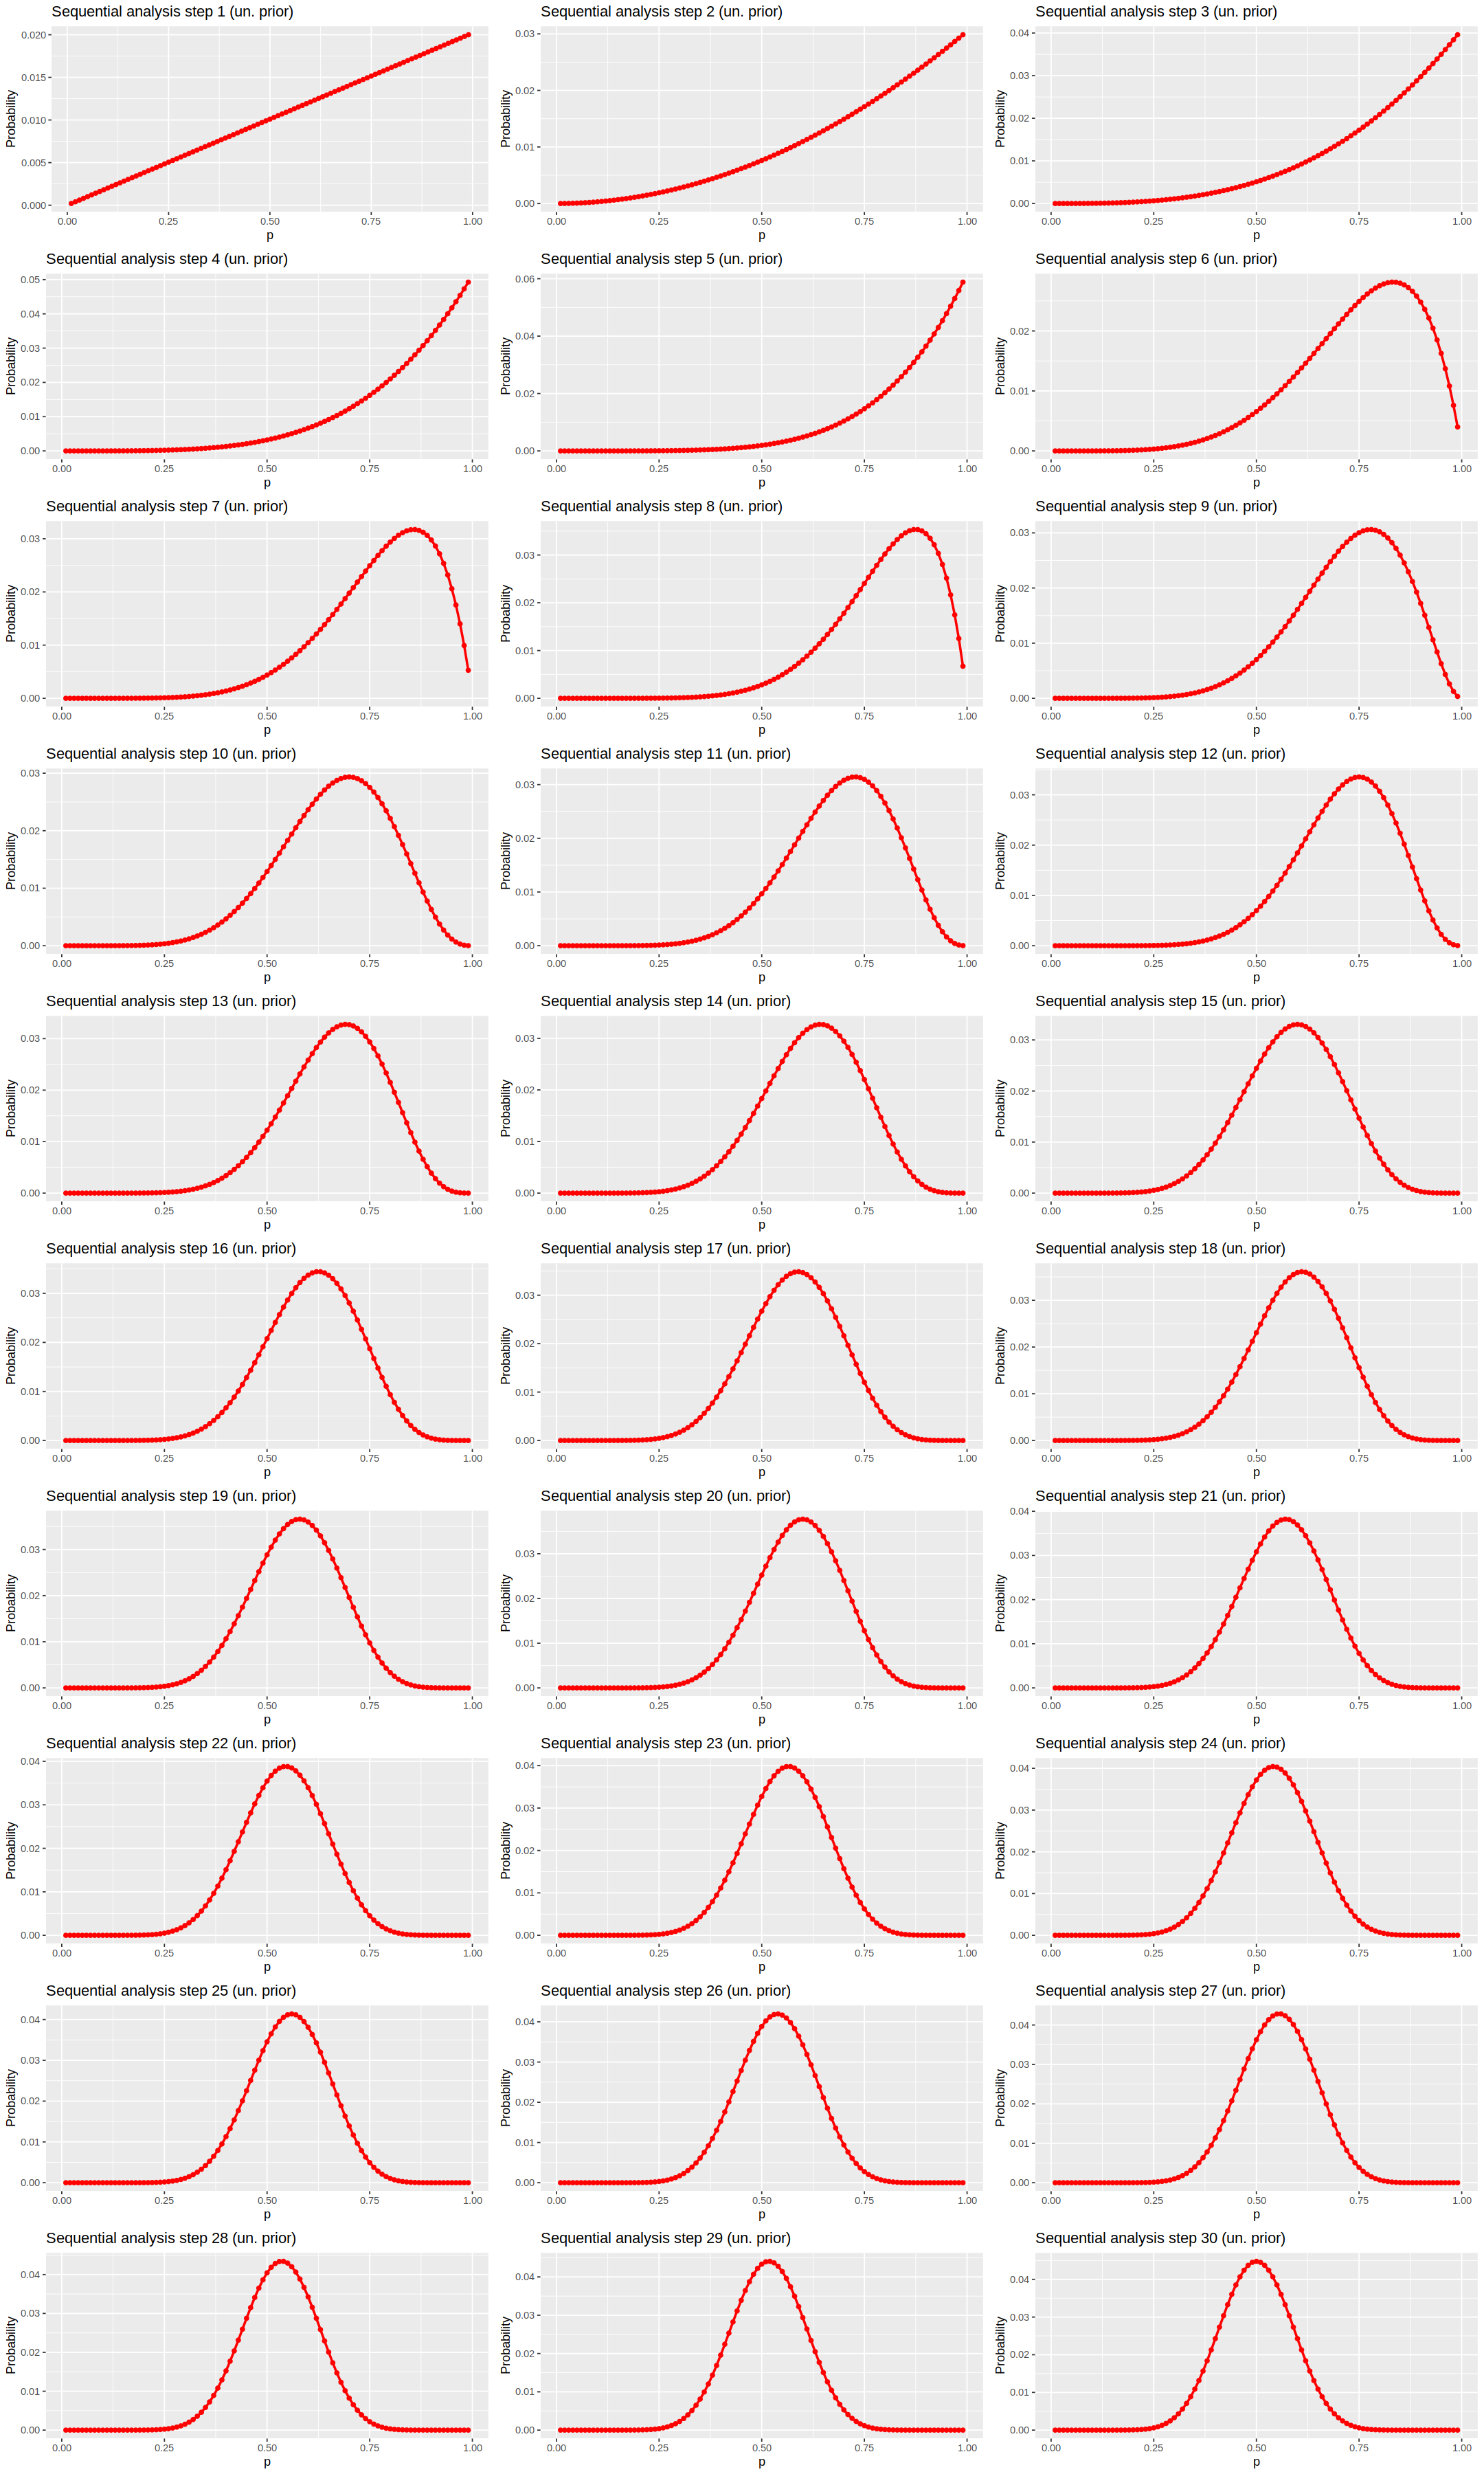

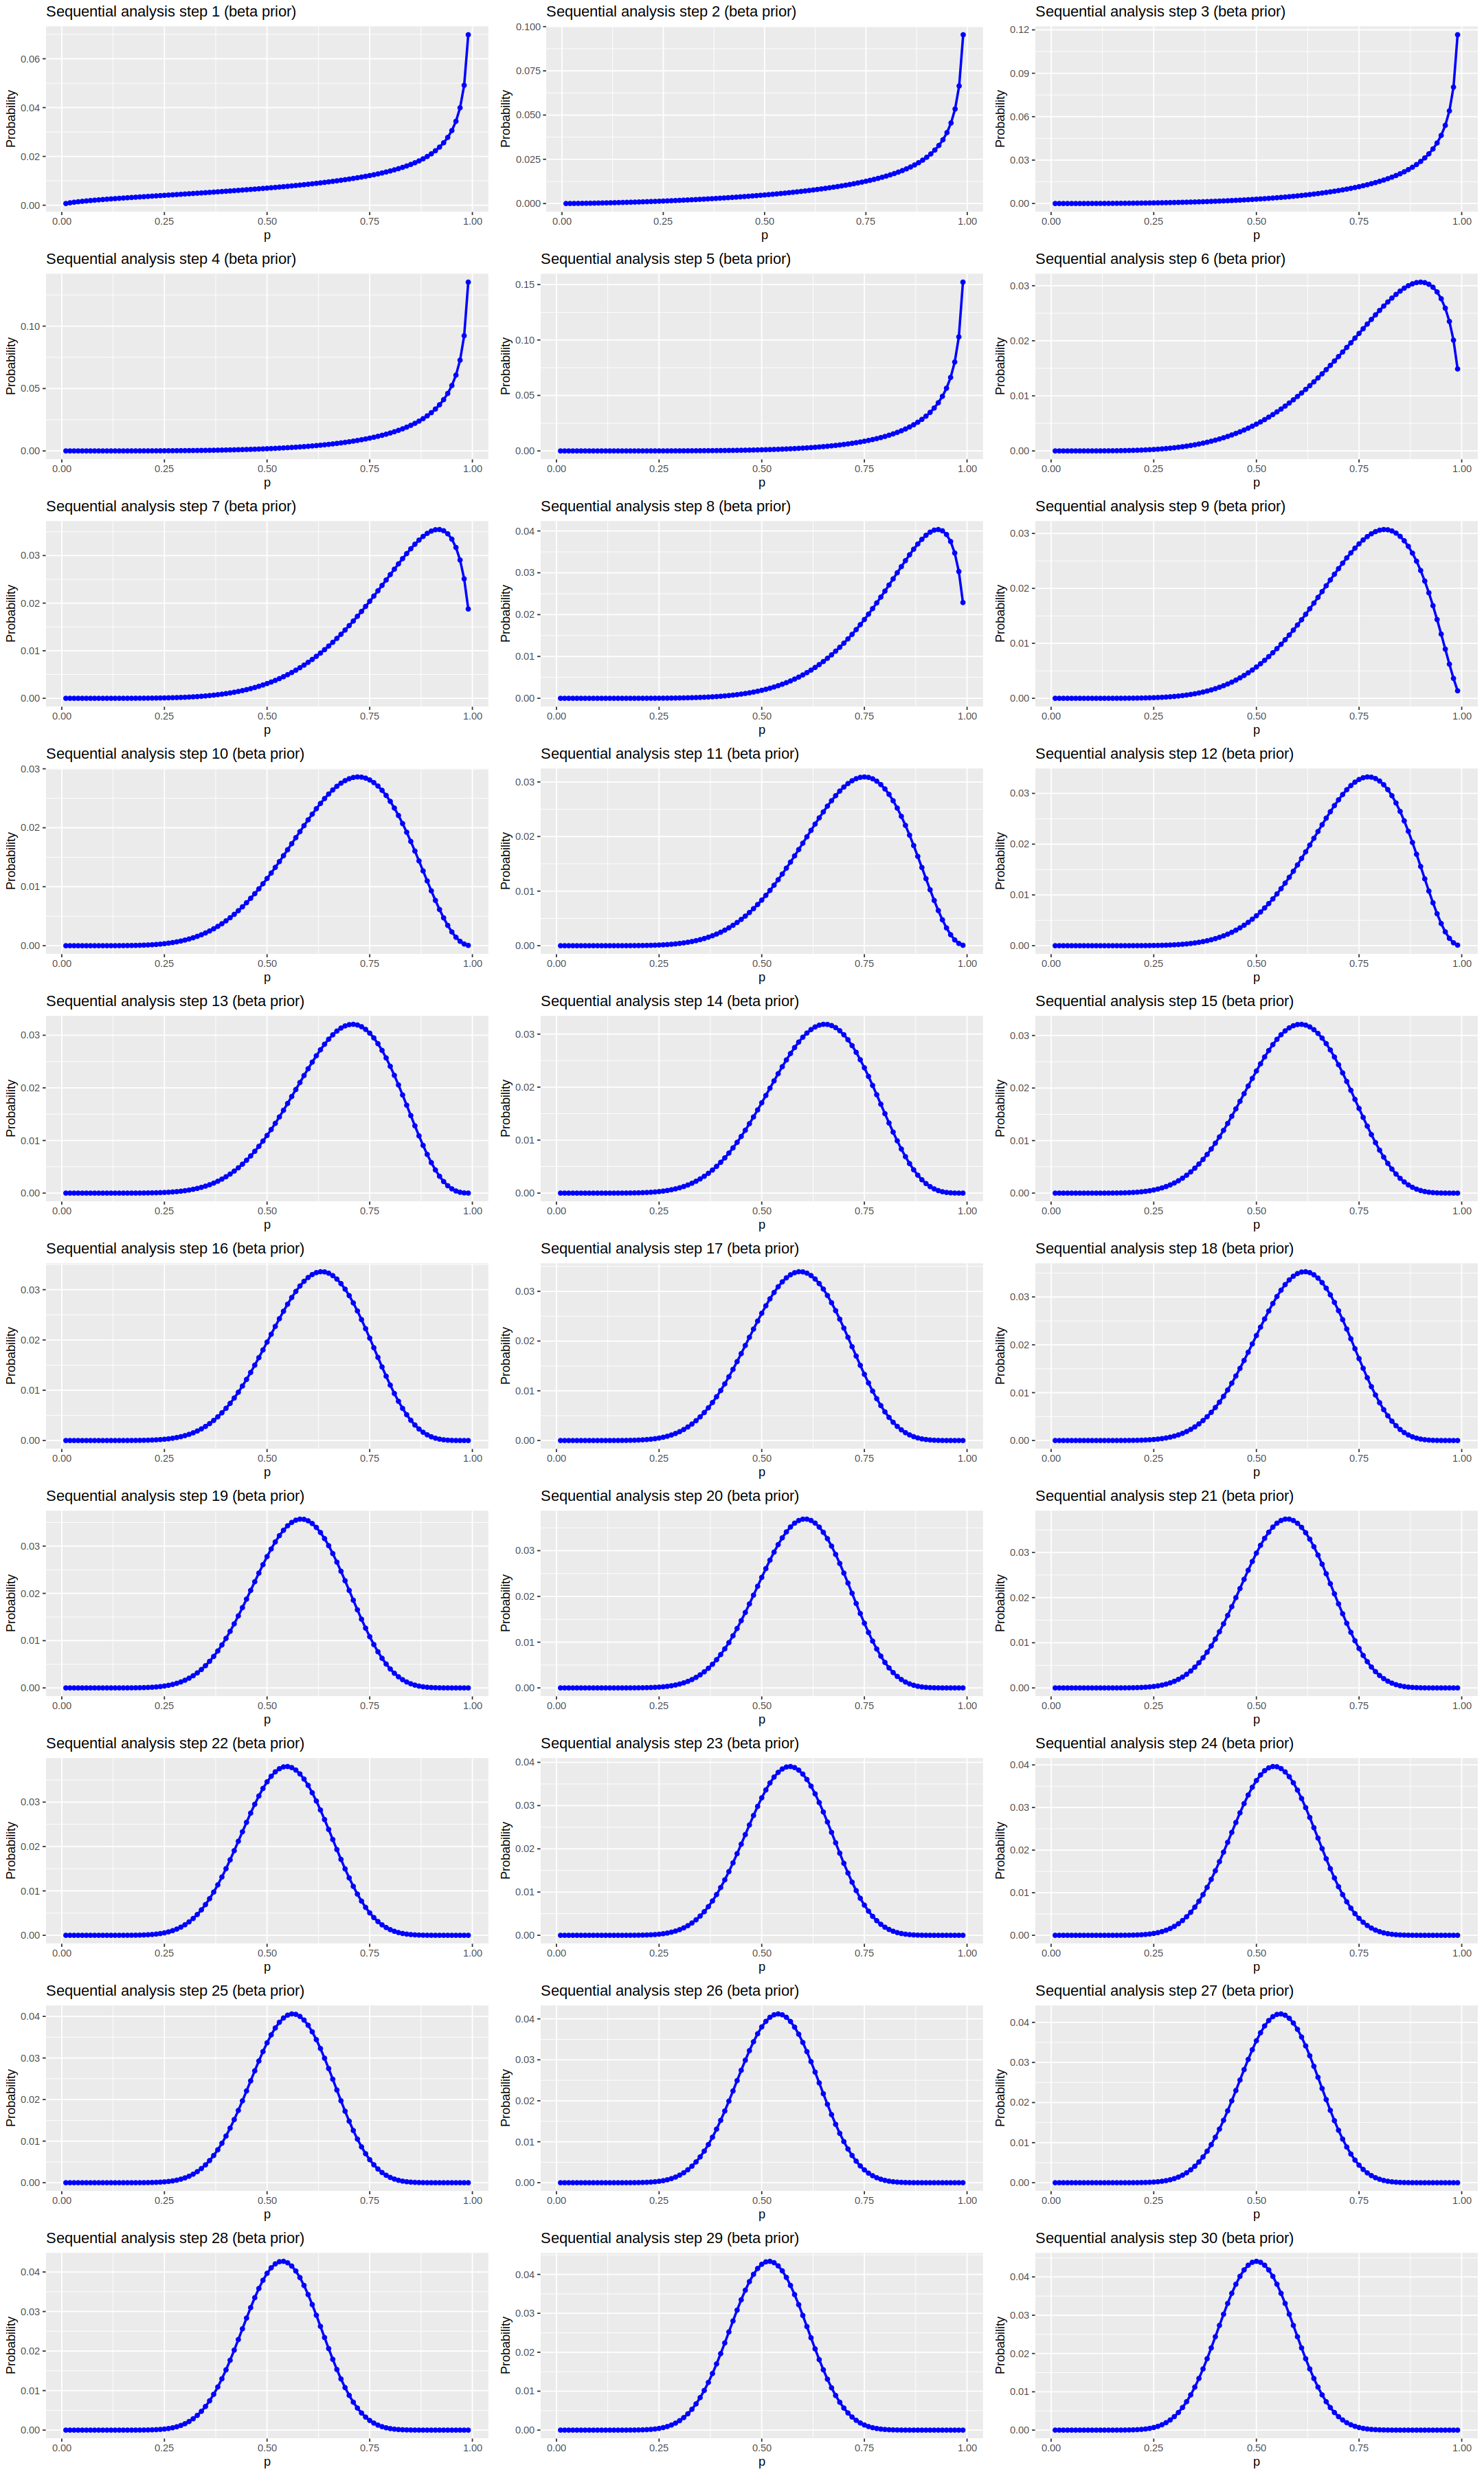

In [38]:
n_it <- length(data)
means <- vector("list", n_it)
means_2 <- vector("list", n_it)
cred_int <- vector("list", n_it)
cred_int_2 <- vector("list", n_it)

for (i in 1:n_it) {
  new_data <- data[1:i]
  n_coin <- length(new_data)
  r_coin <- sum(new_data)

  coin_val <- post_un_bern(r_coin, n_coin, c(min(p), max(p)), p)
  coin_val_2 <- post_beta_bern(r_coin, n_coin, c(a, b), p)

  means[[i]] <- weighted.mean(p, coin_val)
  means_2[[i]] <- weighted.mean(p, coin_val_2)

  cred_int[[i]] <- c_int(coin_val, 0.95, p)
  cred_int_2[[i]] <- c_int(coin_val_2, 0.95, p)

  assign(paste("coin_plot_un_", i, sep = ""),
         ggplot(data = data.frame(p, coin_val),
                aes(x = p, y = coin_val)) +
           geom_point(color = "red", size = 1.5) +
           geom_line(color = "red", linewidth = 1) +
           labs(title = paste("Sequential analysis step", i, "(un. prior)"),
                x = "p",
                y = "Probability"))

  assign(paste("coin_plot_beta_", i, sep = ""),
         ggplot(data = data.frame(p, coin_val_2),
                aes(x = p, y = coin_val_2)) +
           geom_point(color = "blue", size = 1.5) +
           geom_line(color = "blue", linewidth = 1) +
           labs(title = paste("Sequential analysis step", i, "(beta prior)"),
                x = "p",
                y = "Probability"))
}

options(repr.plot.width = 18, repr.plot.height = 30)

plots_un <- lapply(1:n_it, function(i) get(paste("coin_plot_un_", i, sep = "")))
plots_beta <- lapply(1:n_it,
                     function(i) get(paste("coin_plot_beta_", i, sep = "")))

layout_matrix <- matrix(1:n_it, ncol = 3, byrow = TRUE)

grid.arrange(grobs = plots_un, layout_matrix = layout_matrix)
grid.arrange(grobs = plots_beta, layout_matrix = layout_matrix)


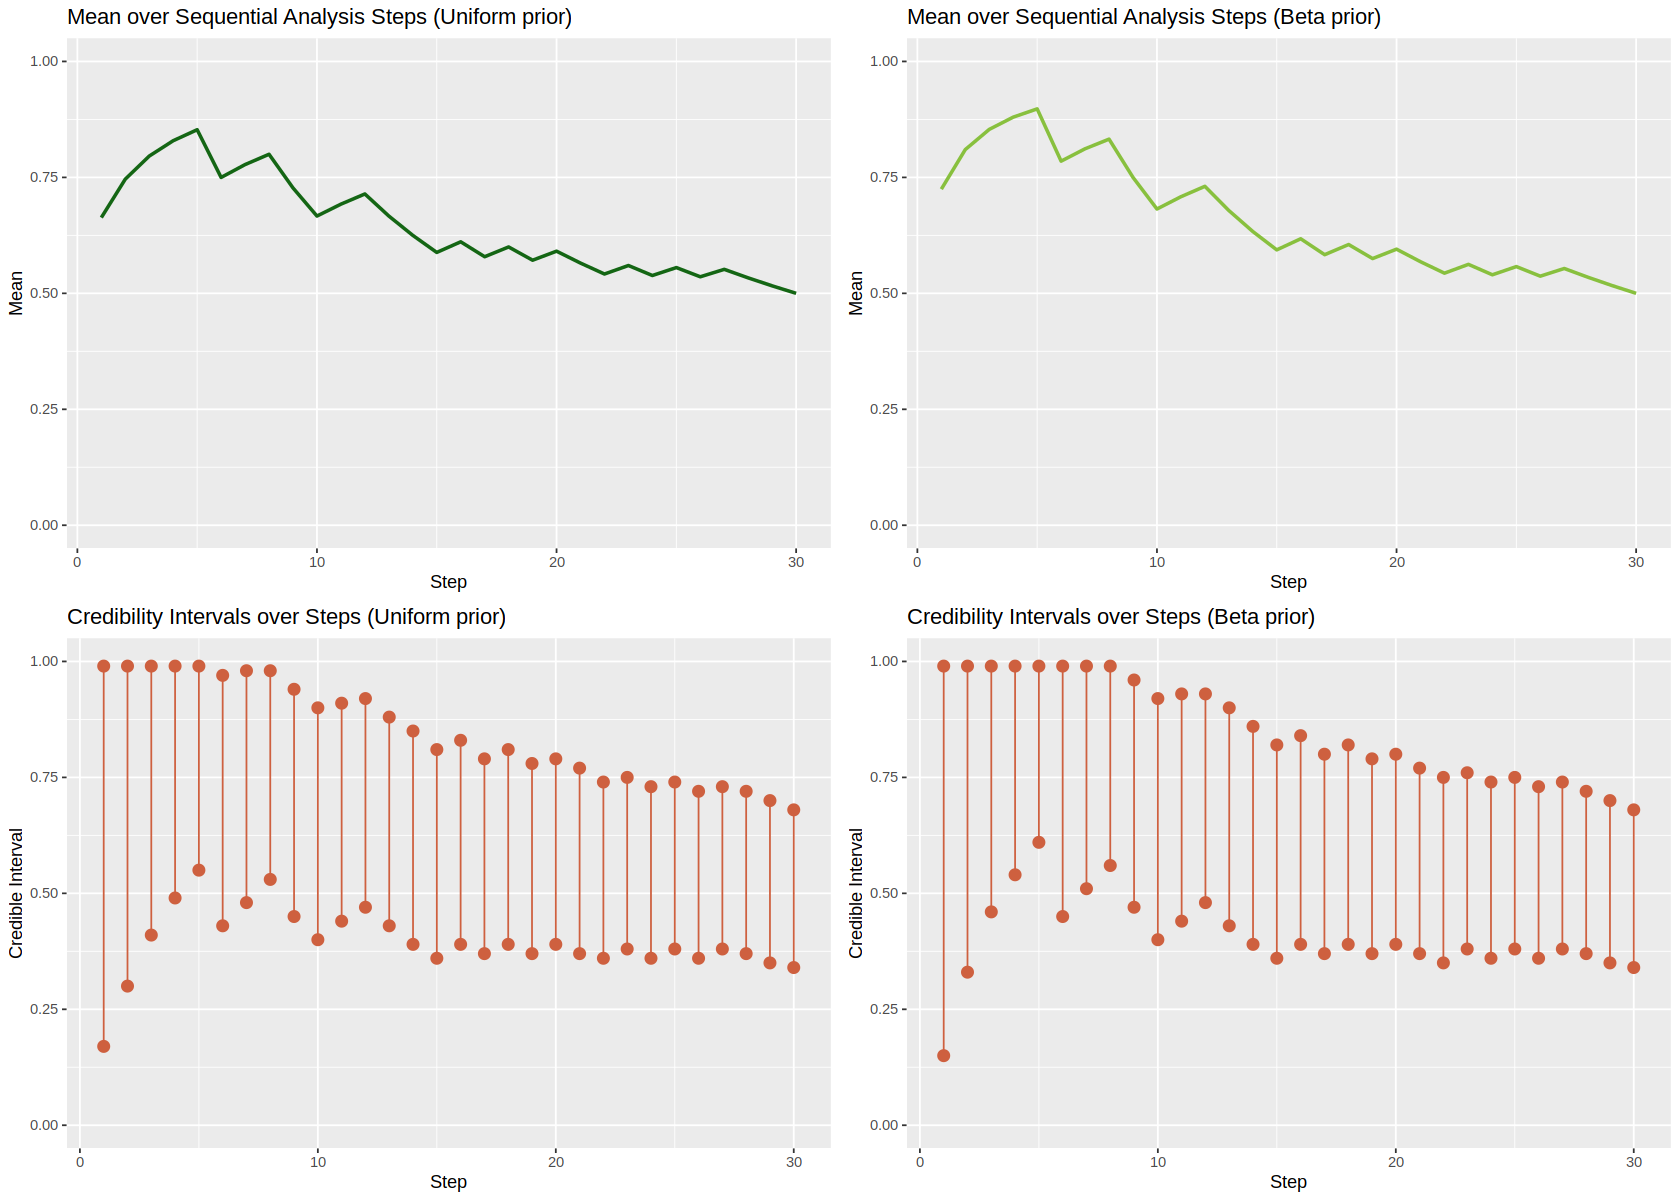

In [39]:
mean_plot <- ggplot(data.frame(step = 1:n_it, mean = unlist(means)),
                    aes(x = step, y = mean)) +
  geom_line(color = "#146614", size = 1) +
  labs(title = "Mean over Sequential Analysis Steps (Uniform prior)",
       x = "Step",
       y = "Mean") +
  coord_cartesian(ylim = c(0, 1))

mean_2_plot <- ggplot(data.frame(step = 1:n_it, mean_2 = unlist(means_2)),
                      aes(x = step, y = mean_2)) +
  geom_line(color = "#88c03e", size = 1) +
  labs(title = "Mean over Sequential Analysis Steps (Beta prior)",
       x = "Step",
       y = "Mean") +
  coord_cartesian(ylim = c(0, 1))

cred_int_df <- data.frame(step = 1:n_it,
                          l_l = sapply(cred_int, "[[", 1),
                          u_l = sapply(cred_int, "[[", 2))

cred_int_plot <- ggplot(cred_int_df, aes(x = step, y = l_l)) +
  geom_point(color = "#ce603f", size = 3) +
  geom_errorbar(aes(ymin = l_l, ymax = u_l), color = "#ce603f", width = 0.2) +
  geom_point(aes(y = u_l), color = "#ce603f", size = 3) +
  labs(title = "Credibility Intervals over Steps (Uniform prior)",
       x = "Step",
       y = "Credible Interval") +
  scale_y_continuous(limits = c(0, 1))

cred_int_2_df <- data.frame(step = 1:n_it,
                            l_l_2 = sapply(cred_int_2, "[[", 1),
                            u_l_2 = sapply(cred_int_2, "[[", 2))

cred_int_2_plot <- ggplot(cred_int_2_df, aes(x = step, y = l_l_2)) +
  geom_point(color = "#ce603f", size = 3) +
  geom_errorbar(aes(ymin = l_l_2, ymax = u_l_2),
                color = "#ce603f", width = 0.2) +
  geom_point(aes(y = u_l_2), color = "#ce603f", size = 3) +
  labs(title = "Credibility Intervals over Steps (Beta prior)",
       x = "Step",
       y = "Credible Interval") +
  scale_y_continuous(limits = c(0, 1))

options(repr.plot.width = 14, repr.plot.height = 10)
grid.arrange(mean_plot, mean_2_plot, cred_int_plot, cred_int_2_plot,
             ncol = 2, nrow = 2)

(d) Do you get a different result, by analysing the data sequentially with respect to a one-step analysis (i.e. considering all the data as a whole)?

No, I obtain the same final result. The most probable value and the confidenxe intervals are the same that we obtained with the one-step analysis, simply with the sequential analysis we can see better how the distribution changes when $n$ increases.

# Exercise 4 - Poll
A couple of days before an election in which four parties (A, B, C, D) compete, a poll is taken using a sample of 200 voters who express the following preferences 57, 31, 45 and 67 for, respectively, parties A, B, C and D.

Using a Bayesian approach, for all parties:

(a) Calculate the expected percentage of votes and a 68% credibility interval by assuming as prior a
- uniform prior
- a prior constructed from the results obtained from another poll conducted the previous week on a sample of 100 voters who expressed the following preferences: 32, 14, 26, 28 for, respectively, parties A, B, C and D.

In [40]:
n_voters <- 200
prefs <- c(57, 31, 45, 67)
parties <- c("A", "B", "C", "D")

votes <- seq(0, n_voters, 1) / n_voters

for (i in seq_along(parties)) {
  post_party <- post_un_bern(prefs[i], n_voters, c(min(votes), max(votes)),
                             votes)

  mean_party <- weighted.mean(votes, post_party)
  c_int_party <- c_int(post_party, 0.68, votes)

  cat("Expected percentage of votes for", parties[i], ":", mean_party, "%\n")
  cat("68% credibility interval for", parties[i], ": (", c_int_party[1], "%, ", c_int_party[2], "%)\n\n") # nolinter
}

Expected percentage of votes for A : 0.2871287 %
68% credibility interval for A : ( 0.26 %,  0.325 %)

Expected percentage of votes for B : 0.1584158 %
68% credibility interval for B : ( 0.14 %,  0.19 %)

Expected percentage of votes for C : 0.2277228 %
68% credibility interval for C : ( 0.205 %,  0.26 %)

Expected percentage of votes for D : 0.3366337 %
68% credibility interval for D : ( 0.31 %,  0.375 %)



In [41]:
prev_n_voters <- 100
prev_prefs <- c(32, 14, 26, 28)

votes <- seq(0, n_voters, 1) / n_voters

post_votes <- function(r, n, prior_values, p) {
  normalization <- sum(prior_values * dbinom(r, n, p))
  return(prior_values * dbinom(r, n, p) / normalization)
}

for (i in seq_along(parties)) {
  prior_party <- post_un_bern(prev_prefs[i], prev_n_voters,
                              c(min(votes), max(votes)), votes)
  post_party <- post_votes(prefs[i], n_voters, prior_party, votes)

  mean_party <- weighted.mean(votes, post_party)
  c_int_party <- c_int(post_party, 0.68, votes)

  cat("Expected percentage of votes for", parties[i], ":", mean_party, "%\n")
  cat("68% credibility interval for", parties[i], ": (", c_int_party[1], "%, ", c_int_party[2], "%)\n\n") # nolinter
}

Expected percentage of votes for A : 0.2980132 %
68% credibility interval for A : ( 0.275 %,  0.33 %)

Expected percentage of votes for B : 0.1523179 %
68% credibility interval for B : ( 0.135 %,  0.18 %)

Expected percentage of votes for C : 0.2384106 %
68% credibility interval for C : ( 0.22 %,  0.27 %)

Expected percentage of votes for D : 0.3178808 %
68% credibility interval for D : ( 0.295 %,  0.35 %)



(b) Calculate the sample size to obtain a margin of error less or equal than ±3% for each party.

In [42]:
calculate_sample_size <- function(p, m_e) {
  z <- qnorm(0.84)
  n <- (p * (1 - p) * z^2) / m_e^2
  return(round(n))
}

sample_sizes <- sapply(prefs / n_voters, calculate_sample_size, m_e = 0.03)

cat("The minimum sample size in order to have a margin of error <= 3% for each party is", max(sample_sizes)) # nolinter

The minimum sample size in order to have a margin of error <= 3% for each party is 245